**Project Description**

The goal of this project is to use natural language processing (NLP) techniques to develop a classification model that can categorize motion expressions based on their morpho-syntactic makeup: 1) 'verb' or V (e.g. saltar-V 'to jump'); 2) 'verb + noun' or VN (e.g. saltar-V la valla-N 'to jump over the fence'), and 3) 'verb + preposition + noun' or VPN (e.g., saltar-V sobre-P la cama-N 'to jump on the bed'). The dataset includes oral (transcribed) samples produced by 31 English learners of Spanish who were asked to describe videos and pictures depicting motion events (e.g., Mr. Bean se dirige hacia las escaleras ‘Mr Bean moves towards the ladder’).

Perform imports

In [3]:
# Perform imports
import pandas as pd
import numpy as np
import seaborn as sns 
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

Load the dataset

There are three columns in the dataset:

Participant: participant number
Speech sample: the actual transcribed description of a motion event
Motion expression type: type of a motion expression (V: 'verb'; VN: 'verb + noun'; VPN: 'verb + preposition + noun'

In [4]:
df = pd.read_csv('/Users/yulia/Documents/python/motion_constr_project/motion_expressions_corpus.csv')
df.head(10)

,participant,speech.sample,motion.expression.type
0,120,y corre por [/] &um por lo &um,VPN
1,120,&um Mr Bean trep(a) [/] trepa del coche &um,VPN
2,120,&um Mr Bean &um sube el calle &um pero &um us(...,VN
3,120,&um Mr Bean corre en el centro comercial &um &...,VPN
4,120,&um Mr Bean corre en su habitación &um con muc...,VPN
5,120,&um Mr Bean pasé [: pasea] [*] en un campo en ...,VPN
6,120,&um # &um Mr Bean vuelve el trampolín por la agua,VN
7,120,&um en un saco Mr Bean [^ eng: like] &um pas(a...,VPN
8,120,&um Mr Bean &um caminé en un túnel [/] túnel &...,VPN
9,120,&um Mr Bean sube las escaleras &um y está un h...,VN


In [5]:
def data_shape(df):
    df_shape = df.shape
    print("The dataset has", df_shape[0], "rows and", df_shape[1], "columns")

data_shape(df)

The dataset has 4314 rows and 3 columns


Check for the existence of missing values

In [63]:
df.isnull().sum()

participant               0
speech_sample             0
motion_expression_type    0
dtype: int64

Data preparation

Converting all characters to lowercase and removing non-word characters in the 'speech sample'.

In [6]:
df['speech.sample'] = [text.lower() for text in df['speech.sample']]

df['speech.sample'] = [re.sub(r'\W+', ' ', text) for text in df['speech.sample']]

df.head(10)

,participant,speech.sample,motion.expression.type
0,120,y corre por um por lo um,VPN
1,120,um mr bean trep a trepa del coche um,VPN
2,120,um mr bean um sube el calle um pero um us a u...,VN
3,120,um mr bean corre en el centro comercial um um...,VPN
4,120,um mr bean corre en su habitación um con much...,VPN
5,120,um mr bean pasé pasea en un campo en un calle...,VPN
6,120,um um mr bean vuelve el trampolín por la agua,VN
7,120,um en un saco mr bean eng like um pas a cami ...,VPN
8,120,um mr bean um caminé en un túnel túnel um y,VPN
9,120,um mr bean sube las escaleras um y está un ho...,VN


Data exploration

AxesSubplot(0.125,0.125;0.775x0.755)


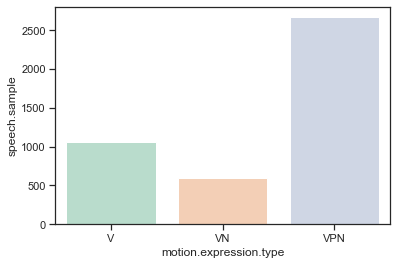

In [7]:
# Using pandas to calculate the frequency of each type of motion expressions

def frequency_of_motion_expression_types(df):
    return df.groupby('motion.expression.type', as_index = False).count()[['speech.sample','motion.expression.type']]

# Using the seaborn library to visualize the data
def barplot_constr_types(df):
    df_subset = frequency_of_motion_expression_types(df)
    sns.set_theme(style="ticks")
    sns.set_palette("Pastel2")
    return sns.barplot(x = "motion.expression.type", y = "speech.sample", data = df_subset)

print(barplot_constr_types(df))

# 'VPN' ( n = 2669) is the most frequently used motion expression, followed by 'V' (n=1054) and 'VN' (n=591).

In [8]:
df['motion.expression.type'].value_counts()

VPN    2669
V      1054
VN      591
Name: motion.expression.type, dtype: int64

Preprocessing

In [9]:
# Splitting the data into training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(df['speech.sample'], df['motion.expression.type'], test_size=0.33, random_state=42)


In [10]:
def explore_dataset(dataset):
    return dataset.describe()

print(explore_dataset(X_train))
print(explore_dataset(X_test))
print(explore_dataset(y_train))
print(explore_dataset(y_test))

count                                   2890
unique                                  2766
top       mr bean está caminando en el andén
freq                                       3
Name: speech.sample, dtype: object
count                                                  1424
unique                                                 1388
top        um la dent ista la dentista está en el piso p...
freq                                                      3
Name: speech.sample, dtype: object
count     2890
unique       3
top        VPN
freq      1789
Name: motion.expression.type, dtype: object
count     1424
unique       3
top        VPN
freq       880
Name: motion.expression.type, dtype: object


In [11]:
# Creating a list of stopwords to add it to CountVectorizer. CountVectorizer will be used to split the dataset into individual words. 
# There are some words in the transcribed speech samples that may influence the classification of motion expressions. 
# I'm going to create my own list of stopwords to remove them from the text.

stopwords = ['um', 'mr', 'eng', '1']


In [12]:
# Building a pipeline to vectorize the data, then train and fit a model
# I will be using a Multinomial Naive Bayes classifier because it is suitable for classification with dicrete type (e.g., frequency word counts).

motion_expr_clf_nb = Pipeline([('tfidf', CountVectorizer(stop_words=stopwords)),
                     ('clf', MultinomialNB()),
])

In [13]:
#Feeding the training data through the first pipeline
motion_expr_clf_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', CountVectorizer(stop_words=['um', 'mr', 'eng', '1'])),
                ('clf', MultinomialNB())])

Run predictions and analyze the results

In [15]:
# Form a prediction (testing) set
# After I have fitted the model, I can use it on the testing dataset to predict the types of motion expressions (i.e., 'V', 'VN', 'VPN'). 
predictions = motion_expr_clf_nb.predict(X_test)

In [16]:
# Evaluating the model
### Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))

[[138  26 201]
 [ 11  76  92]
 [ 41  39 800]]


In [17]:
#Adding labels to the confusion matrix to make less confusing
df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions), index=['V','VN', 'VPN'], 
                  columns=['V','VN', 'VPN'])
df

# More 'V' motion expressions were classified as 'VPN' (n=201) and 'VN' (n=26) than correctly identified as 'V' (n=138). 
# Similarly, there were more 'VN' expressions incorrectly classified as 'VPN' (n=92) and 'V' (n=11) than correctly identified as 'VN' (n=76).
# In contast, a relatively small number of 'VPN' expressions were confused as 'V' (n=41) and 'VN' (n=39).


,V,VN,VPN
V,138,26,201
VN,11,76,92
VPN,41,39,800


In [19]:
# Print a classification report to evaluate the model using accuracy, precision, and recall
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

           V       0.73      0.38      0.50       365
          VN       0.54      0.42      0.48       179
         VPN       0.73      0.91      0.81       880

    accuracy                           0.71      1424
   macro avg       0.67      0.57      0.59      1424
weighted avg       0.71      0.71      0.69      1424



In [20]:
print("Accuracy:",metrics.accuracy_score(y_test,predictions))
print("Precision:", metrics.precision_score(y_test,predictions, average = None))
print("Recall:", metrics.recall_score(y_test,predictions, average = None))

Accuracy: 0.7120786516853933
Precision: [0.72631579 0.53900709 0.73193047]
Recall: [0.37808219 0.42458101 0.90909091]


In [21]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.7120786516853933


The accuracy of our model is about 71%, which is not too high. This could be explained by a relatively small dataset. In addition, this could be due to the nature of the dataset. The model was trained on the speech samples produced by Spanish language learners who do not always use target-like (i.e., grammatically correct) motion expressions.